In [1]:
from google.colab import drive
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [2]:
pip install hazm

## Prerequisites

### Importing Necessary Libraries

In [3]:
import numpy as np
import pandas as pd
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import GridSearchCV
from matplotlib import pyplot as plt

### Confusion Matrix Plotting Tool

In [4]:
def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if not title:
        if normalize:
            title = 'Normalized Confusion Matrix'
        else:
            title = 'Confusion Matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    # Only use the labels that appear in the data
    # classes = classes[unique_labels(y_true, y_pred)]
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized Confusion Matrix")
    else:
        print('Confusion Matrix, without normalization')

    print(cm)

    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    plt.xlim(-0.5, len(np.unique(y_test))-0.5)
    plt.ylim(len(np.unique(y_test))-0.5, -0.5)
    return ax

### Character Set & File Paths

In [5]:
file_path = '/content/drive/My Drive/Colab Notebooks/Social Computing/emails/'

persian_chars = {'آ', 'ا', 'ب', 'پ', 'ت', 'ث', 'ج', 'چ', 'ح', 'خ', 'د', 'ذ', 'ر',
                 'ز', 'ژ', 'س', 'ش', 'ص', 'ض', 'ط', 'ظ', 'ع', 'غ', 'ف', 'ق', 'ک',
                 'گ', 'ل', 'م', 'ن', 'و', 'ه', 'ی', ' ', '‌'}

### Normalizing the Character Set

In [6]:
# Removing illegal characters
def clean_chars(data):
    text = ''
    for i in range(len(data)):
        if data[i] not in persian_chars:
            if data[i] == 'ي':
                text += 'ی'
            elif data[i] == 'أ' or data[i] == 'إ':
                text += 'ا'
            elif data[i] == 'ك':
                text += 'ک'
            else:
                text += ' '
        else:
            text += data[i]
    data = text
    return data

In [7]:
ham_training = []
spam_training = []
ham_testing = []
spam_testing = []

# A set of all unique words
vocab = set()

### Preprocessing Tools

In [8]:
from __future__ import unicode_literals
from hazm import *
normalize = Normalizer().normalize
stem = Stemmer().stem
stopwords = set(stopwords_list())

## Reading *Training* files
Removing unwanted characters and stopwords, normalizing, and decompossing into words.
Then converting the words to their stems.

In [9]:
# Iterating through 300 training tweets
for i in range(300):

    # Name of the corresponding "ham" file
    file_name = 'hamtraining (' + str(i + 1) + ').txt'
    # Opening the file
    with open(file_path + 'hamtraining/' + file_name, encoding='utf-8') as tweet:
        # Cleaning the text, Normalizing it, and the splitting into words
        ham_training.append(word_tokenize(normalize(clean_chars(tweet.read()))))
    # Omitting stopwords and stemming the remaining words
    temp = []
    for j in range(len(ham_training[i])):
        if ham_training[i][j] not in stopwords:
            temp.append(stem(ham_training[i][j]))
            if stem(ham_training[i][j]) not in vocab:
                vocab.add(stem(ham_training[i][j]))
    ham_training[i] = temp
    # Closing the file
    tweet.close()

    # Name of the corresponding "spam" file
    file_name = 'spamtraining (' + str(i + 1) + ').txt'
    # Opening the file
    with open(file_path + 'spamtraining/' + file_name, encoding='utf-8') as tweet:
        # Cleaning the text, Normalizing it, and the splitting into words
        spam_training.append(word_tokenize(normalize(clean_chars(tweet.read()))))
    # Omitting stopwords and stemming the remaining words
    temp = []
    for j in range(len(spam_training[i])):
        if spam_training[i][j] not in stopwords:
            temp.append(stem(spam_training[i][j]))
            if stem(spam_training[i][j]) not in vocab:
                vocab.add(stem(spam_training[i][j]))
    spam_training[i] = temp
    # Closing the file
    tweet.close()

## Reading *Testing* files
Removing unwanted characters and stopwords, normalizing, and decompossing into words.
Then converting the words to their stems.

In [10]:
# Iterating through 200 testing tweets
for i in range(200):

    # Name of the corresponding "ham" file
    file_name = 'hamtesting (' + str(i + 1) + ').txt'
    # Opening the file
    with open(file_path + 'hamtesting/' + file_name, encoding='utf-8') as tweet:
        # Cleaning the text, Normalizing it, and the splitting into words
        ham_testing.append(word_tokenize(normalize(clean_chars(tweet.read()))))
    # Omitting stopwords and stemming the remaining words
    temp = []
    for j in range(len(ham_testing[i])):
        if ham_testing[i][j] not in stopwords:
            temp.append(stem(ham_testing[i][j]))
    ham_testing[i] = temp
    # Closing the file
    tweet.close()

    # Name of the corresponding "spam" file
    file_name = 'spamtesting (' + str(i + 1) + ').txt'
    # Opening the file
    with open(file_path + 'spamtesting/' + file_name, encoding='utf-8') as tweet:
        # Cleaning the text, Normalizing it, and the splitting into words
        spam_testing.append(word_tokenize(normalize(clean_chars(tweet.read()))))
    # Omitting stopwords and stemming the remaining words
    temp = []
    for j in range(len(spam_testing[i])):
        if spam_testing[i][j] not in stopwords:
            temp.append(stem(spam_testing[i][j]))
    spam_testing[i] = temp
    # Closing the file
    tweet.close()

## Convertion to Data Frames
Constructing *`DataFrame`s* from lists, using *`pandas`*.

In [11]:
df_train = pd.DataFrame(list(zip(ham_training + spam_training, [False] * 300 + [True] * 300)), columns=['email', 'is_spam'])
df_test = pd.DataFrame(list(zip(ham_testing + spam_testing, [False] * 200 + [True] * 200)), columns=['email', 'is_spam'])

## Generating *Pickle* files
Constructing *Word-to-Index* and *Index-to-Word* dictionaries.

In [12]:
word2index = dict((word, index) for index, word in enumerate(vocab))
index2word = dict((index, word) for index, word in enumerate(vocab))

## Count Vectorizer

In [13]:
count_vector = np.zeros((600, len(vocab)))
for i in range(600):
    for word in df_train['email'][i]:
        count_vector[i, word2index[word]] += 1

## $cosine$ Similarity

In [14]:
def cosine_similarity(a, b):
    return np.dot(a, b) / (np.linalg.norm(a) * np.linalg.norm(b))

## **$KNN$** using $cosine$ Similarity Metric

In [15]:
# Default: k = 5
def KNN_cosine_similarity(X_train, y_train, email, k=5):
    email_vector = np.zeros(len(vocab))
    for word in email:
        if word in vocab:
            email_vector[word2index[word]] += 1

    # Distances in a dictionary with index as the primary key
    distance = {}
    for i in range(600):
        distance[i] = cosine_similarity(email_vector, count_vector[i])

    # Sorting distances into descending order
    sorted_distance = sorted(distance.items(), key=lambda kv: kv[1], reverse=True)

    # k neerest neighbors
    top_k = sorted_distance[:k]

    # Flag as "Genuine"-->False or "Spam"-->True
    category = 0
    for neighbor in top_k:
        if y_train[neighbor[0]]:
            category += 1
        else:
            category -= 1
    if category > 0:
        return True
    
    return False

### Prediction of the *Test* Data
**Set** $K=7$.

In [16]:
y_test = [False] * 200 + [True] * 200
y_prediction = [KNN_cosine_similarity(df_train['email'], df_train['is_spam'],
                                      df_test['email'][i], k=7) for i in range(400)]

#### Classification Report

In [17]:
print(classification_report(y_test, y_prediction))

              precision    recall  f1-score   support

       False       0.95      0.91      0.93       200
        True       0.91      0.95      0.93       200

    accuracy                           0.93       400
   macro avg       0.93      0.93      0.93       400
weighted avg       0.93      0.93      0.93       400



#### Plotting the Confusion Matrix

Normalized Confusion Matrix
[[0.91  0.09 ]
 [0.045 0.955]]


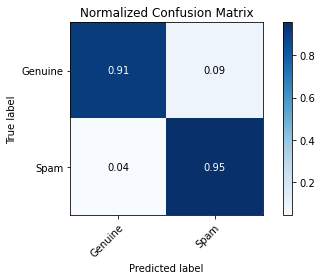

In [18]:
plt.show(plot_confusion_matrix(y_test, y_prediction, classes=['Genuine', 'Spam'], normalize=True))

## **$KNN$** using $TF/IDF$ Score Metric

**Term Frequency (TF)** computation function

In [19]:
def TF(wordDict, bagOfWords):
    tf_dict = {}
    bagOfWordsCount = len(bagOfWords)
    for word, count in wordDict.items():
        if count:
            tf_dict[word] = np.log(count) + 1
        else:
            tf_dict[word] = 0
    return tf_dict

**Inverse Document Frequency (IDF)** computation function

In [20]:
def IDF(vocab):
    N = len(df_train)
    
    idf_dict = dict.fromkeys(vocab, 0)
    for email in df_train['email']:
        for word in email:
            idf_dict[word] += 1
    
    for word, val in idf_dict.items():
        idf_dict[word] = np.log(N / float(val))
    return idf_dict

**Term Frequency/Inverse Document Frequency (TF/IDF)** computation function

In [21]:
def TFIDF(tfBagOfWords, idf):
    tfidf = {}
    for word, value in tfBagOfWords.items():
        tfidf[word] = value * idf[word]
    return tfidf

In [22]:
# Default: k = 5
def KNN_TFIDF(X_train, y_train, email, k=5):
    email_vector = np.zeros(len(vocab))
    for word in email:
        if word in vocab:
            email_vector[word2index[word]] += 1

    # Distances in a dictionary with index as the primary key
    distance = {}

    # Inverse Document Frequency
    idf = IDF(vocab)

    # Computing TF/IDF score for all words in the new email
    for i in range(600):
        number_of_words = dict.fromkeys(vocab, 0)
        for word in df_train['email'][i]:
            number_of_words[word] += 1
        score = 0
        tf = TF(number_of_words, df_train['email'][i])
        for word in email:
            if word in tf and word in idf:
                score += tf[word] * idf[word]
        distance[i] = score

    # Sorting distances into descending order
    sorted_distance = sorted(distance.items(), key=lambda kv: kv[1], reverse=True)

    # k neerest neighbors
    top_k = sorted_distance[:k]
    
    # Flag as "Genuine"-->False or "Spam"-->True
    category = 0
    for neighbor in top_k:
        if y_train[neighbor[0]]:
            category += 1
        else:
            category -= 1
    if category > 0:
        return True
    
    return False

### Prediction of the *Test* Data
**Set** $K=7$.

In [23]:
y_test = [False] * 200 + [True] * 200
y_prediction = [KNN_TFIDF(df_train['email'], df_train['is_spam'],
                    df_test['email'][i], k=7) for i in range(400)]

#### Classification Report

In [24]:
print(classification_report(y_test, y_prediction))

              precision    recall  f1-score   support

       False       0.96      0.82      0.89       200
        True       0.85      0.97      0.90       200

    accuracy                           0.90       400
   macro avg       0.91      0.90      0.90       400
weighted avg       0.91      0.90      0.90       400



#### Plotting the Confusion Matrix

Normalized Confusion Matrix
[[0.825 0.175]
 [0.03  0.97 ]]


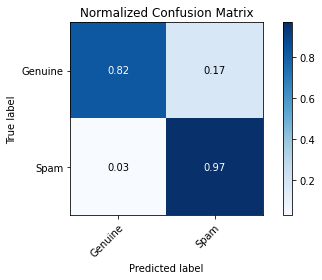

In [25]:
plt.show(plot_confusion_matrix(y_test, y_prediction, classes=['Genuine', 'Spam'], normalize=True))

## Using $\chi^2$ to Find the Most Determinal Words

In [26]:
# Select 200 features with highest chi-squared statistics
chi2_selector = SelectKBest(chi2, k=200)
chi2_selector.fit(count_vector, df_train['is_spam'])

# Look at scores returned from the selector for each feature
chi2_scores = pd.DataFrame(list(zip(vocab, chi2_selector.scores_, chi2_selector.pvalues_)), 
                                       columns=['feature', 'score', 'p-value'])

chi2_scores.sort_values(by=['score'], ascending=False)[:200]

,feature,score,p-value
3509,خرید,1109.088574,3.495767e-243
8243,محصول,746.414322,2.415792e-164
8743,تو,666.595573,5.495031e-147
156,قیم,637.590842,1.116602e-140
2369,پست,515.007707,5.160494e-114
...,...,...,...
8491,غذا,46.620690,8.614589e-12
4275,ایجاد,46.612903,8.648887e-12
6899,دقیقه,46.538462,8.983769e-12
5127,بذر,46.000000,1.182530e-11
